## Random Forest Analysis 

### Import Data

In [1]:
import pandas as pd

df = pd.read_excel("finaldf_partner_imp_1k.xlsx", index_col=False)
df.drop(columns=["Column1","index_x", "index_y","symbol", "calendarYear", "revenue_to_Revenue_ratio", "marketCap"], axis = 1, inplace = True)
df

,Label,Partner,totalCurrentAssets_to_totalAssets_ratio,totalNonCurrentAssets_to_totalAssets_ratio,totalCurrentLiabilities_to_totalLiabilities_ratio,totalNonCurrentLiabilities_to_totalLiabilities_ratio,costOfRevenue_to_Revenue_ratio,grossProfit_to_Revenue_ratio,operatingExpenses_to_Revenue_ratio,ebitda_to_Revenue_ratio,...,investmentsInPropertyPlantAndEquipment_to_Revenue_ratio,commonStockIssued_to_Revenue_ratio,debtRepayment_to_Revenue_ratio,debtToEquity,debtToAssets,daysOfInventoryOnHand,workingCapital_to_revenue_Ratio,employee_revenue_ratio,Number of Product Segments,Number of Geo Segments
0,2,263.0,52.543267,47.456733,65.918286,34.081714,72.963421,27.036579,19.487096,7.270342,...,-2030.050116,0.669815,-1346.597918,0.469952,0.149550,80.392441,16.931293,0.000226,3,3
1,2,263.0,50.142358,49.857642,62.165864,37.834136,74.850994,25.149006,19.476318,15.567115,...,-1607.798758,2.513364,-993.654078,0.680004,0.202260,92.362922,15.423757,0.000234,3,3
2,2,263.0,47.520648,52.479352,68.611247,31.388753,75.073354,24.926646,17.734589,13.704331,...,-294.934587,166.070145,164.719169,0.720136,0.225146,96.741438,7.261509,0.000242,3,3
3,2,263.0,47.422916,52.577084,72.094450,27.905550,75.286739,24.713261,17.837664,12.844175,...,-354.411168,201.877065,200.226144,0.447787,0.177048,73.346435,7.006217,0.000251,4,3
4,2,263.0,47.904926,52.095074,75.492625,24.507375,73.459118,26.540882,18.771963,12.410075,...,-636.935020,362.817037,359.850068,0.206887,0.096555,77.153320,10.813318,0.000259,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,630.0,78.044646,21.955354,81.364396,18.635604,18.456237,81.543763,79.677899,3.986179,...,-0.880229,0.015021,-0.002659,0.007070,0.003336,158.281749,37.631347,0.000256,3,3
996,1,630.0,84.934391,15.065609,73.224070,26.775930,18.532806,81.467194,79.428193,4.680740,...,-1.028563,14.597445,-3.376195,0.086897,0.056183,366.126036,122.329112,0.000407,3,3
997,1,630.0,90.465673,9.534327,87.666519,12.333481,31.002449,68.997551,44.110474,25.975459,...,-1.690109,38.980069,2.602229,0.027460,0.020011,110.037428,133.248157,0.000167,3,3
998,1,630.0,81.890433,18.109567,89.182578,10.817422,25.721682,74.278318,48.336213,26.050084,...,-0.474028,6.502011,-0.572266,0.018290,0.014000,111.508107,112.299237,0.000166,3,3


In [2]:
columns_to_scale = [ "totalCurrentAssets_to_totalAssets_ratio", "totalNonCurrentAssets_to_totalAssets_ratio", "totalCurrentLiabilities_to_totalLiabilities_ratio",
                    "totalNonCurrentLiabilities_to_totalLiabilities_ratio", "costOfRevenue_to_Revenue_ratio",
                    "grossProfit_to_Revenue_ratio", "operatingExpenses_to_Revenue_ratio", "ebitda_to_Revenue_ratio", 
                     "investmentsInPropertyPlantAndEquipment_to_Revenue_ratio",
                    "commonStockIssued_to_Revenue_ratio","debtRepayment_to_Revenue_ratio", "debtToEquity", 
                    "debtToAssets", "workingCapital_to_revenue_Ratio", "employee_revenue_ratio"]

In [3]:
df_top_10 = df[["grossProfit_to_Revenue_ratio", "ebitda_to_Revenue_ratio", 
                "commonStockIssued_to_Revenue_ratio","debtRepayment_to_Revenue_ratio", "debtToAssets",
                "workingCapital_to_revenue_Ratio", "employee_revenue_ratio","acquisitionsNet_to_Revenue_ratio",
                "daysOfInventoryOnHand", "Label"]]


### Data Organisation

In [4]:
def remove_outliers(df):
    
    
    # Keep only numeric columns for outlier removal
    df_numeric = df.select_dtypes(include=[float])

    # Calculate lower and upper quantiles
    lower_quantiles = df_numeric.quantile(0.01)
    upper_quantiles = df_numeric.quantile(0.99)
    means = df_numeric.mean()

    # Filter out the outliers
    for col in df_numeric.columns:
        df_numeric = df_numeric[(df_numeric[col] > lower_quantiles[col]) &
                                (df_numeric[col] < upper_quantiles[col]) &
                                (df_numeric[col] <= 500) &
                                (df_numeric[col] >= -500)]
    
    # Create a filtered DataFrame with the original non-numeric columns
    df_filtered = df.loc[df_numeric.index]
     
    return df_filtered
# Apply the function
filtered_df = remove_outliers(df_top_10)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pylab as plt
import numpy as np

# Separate explanatory (X) and target (y) variables
X = filtered_df.copy()
y = X.pop("Label")

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 
# Create a DataFrame with the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


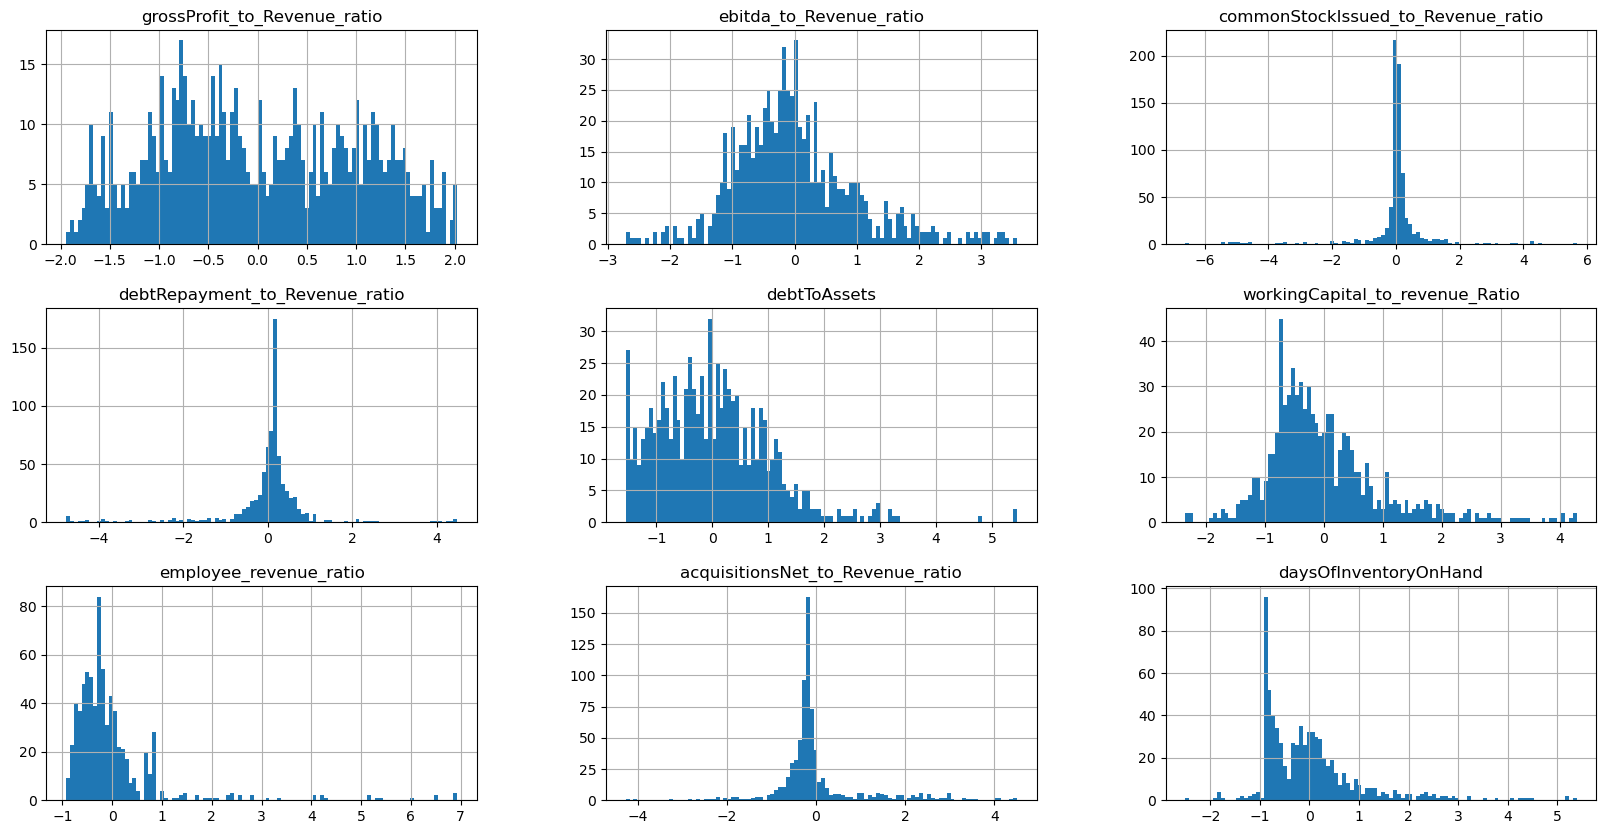

In [6]:
plt.rcParams["figure.figsize"] = (20,10)
X_scaled_df.select_dtypes(exclude="bool").hist(bins=100)
plt.show()

## Random Forest Analysis

### Grid Search to find the best Hyperparameters to Regulate

In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix

# Assuming X_scaled_df and y are your features and target variables
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=123)


class_weight = {1:1, 2:1, 3:1, 4:10}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=123, class_weight=class_weight)

param_grid_no_bootstrap = {
    'criterion': ["gini", "entropy"],
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [False, True]
}

# Combine the parameter grids
param_grid = [param_grid_no_bootstrap]

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Calibrate the best estimator
calibrated_rf_model = CalibratedClassifierCV(best_rf_model, method='sigmoid')
calibrated_rf_model.fit(X_train, y_train)

# Predict on the test set using the calibrated model
y_pred = calibrated_rf_model.predict(X_test)

# Output the five cross-validation scores
cv_scores = cross_val_score(calibrated_rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Test set accuracy:", accuracy)
print("Test set precision:", precision)
print("Test set recall:", recall)
print("Test set F1 score:", f1)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8632590900437845
Cross-validation scores: [0.83495146 0.86407767 0.88235294 0.7745098  0.88235294]
Mean cross-validation score: 0.8476489624976203
Test set accuracy: 0.8681818181818182
Test set precision: 0.8735048096369703
Test set recall: 0.8681818181818182
Test set F1 score: 0.8688652312131249
Classification report:
               precision    recall  f1-score   support

           1       0.79      0.83      0.81        59
           2       0.93      0.93      0.93        68
           3       0.93      0.82      0.87        66
           4       0.78      0.93      0.85        27

    accuracy                           0.87       220
   macro avg       0.86      0.88      0.86       220
weighted avg       0.87      0.87      0.87       220

Confusion matrix:
 

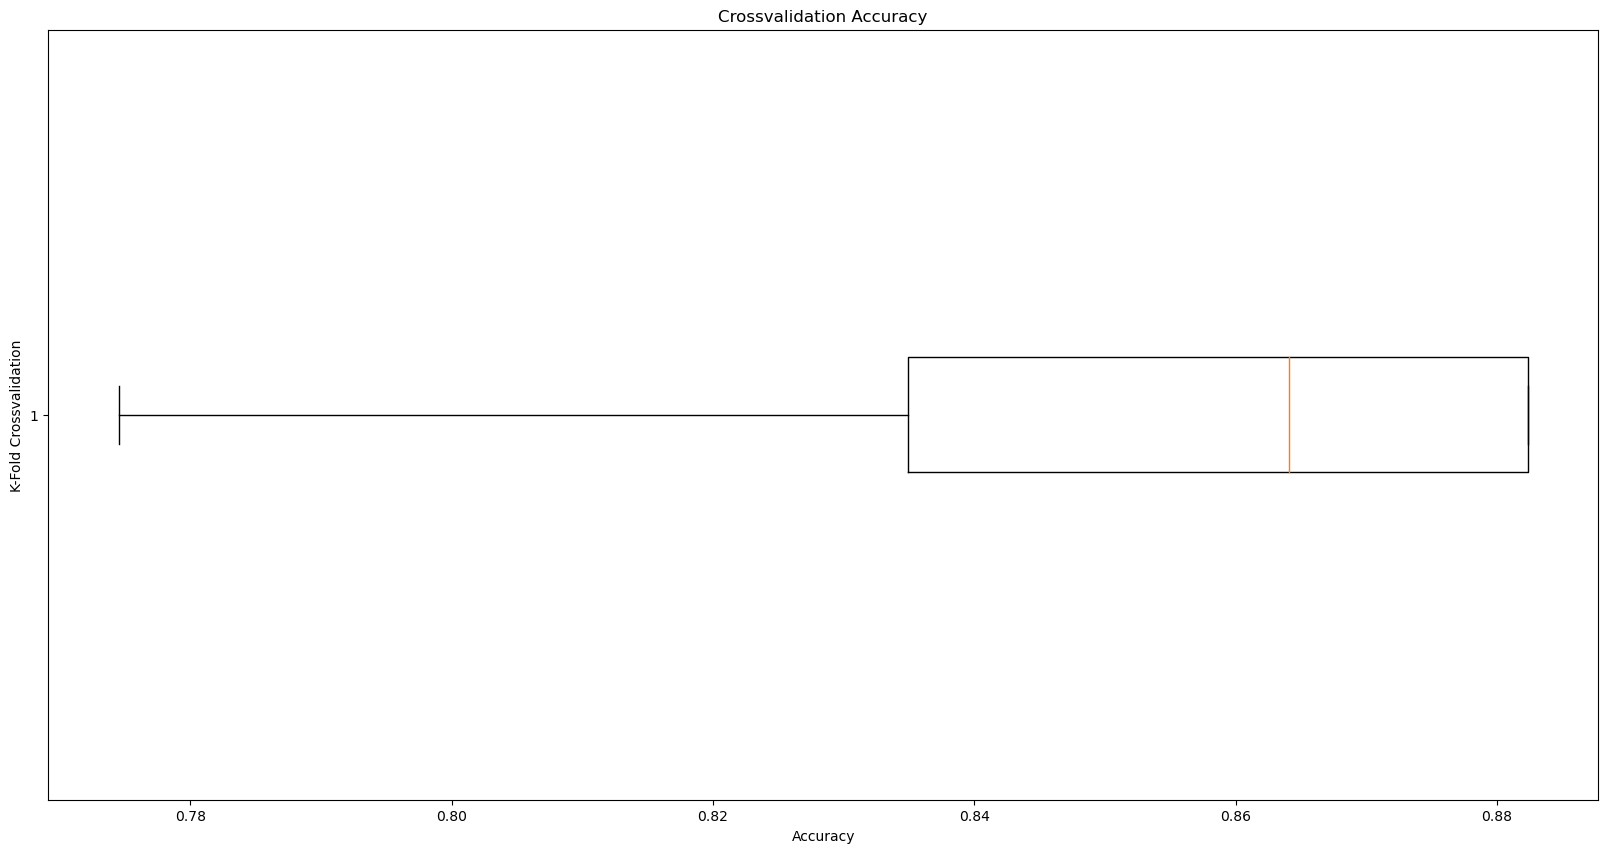

In [8]:
plt.figure(figsize=(20,10))
plt.boxplot(cv_scores, vert = False)
plt.xlabel("Accuracy")
plt.ylabel("K-Fold Crossvalidation")
plt.title("Crossvalidation Accuracy")
plt.savefig("CV_Scores.png")
plt.show()

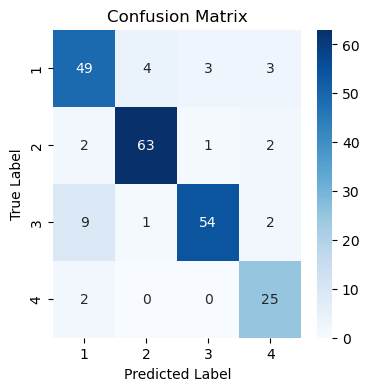

In [9]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Learning Curve Visulaizatuion

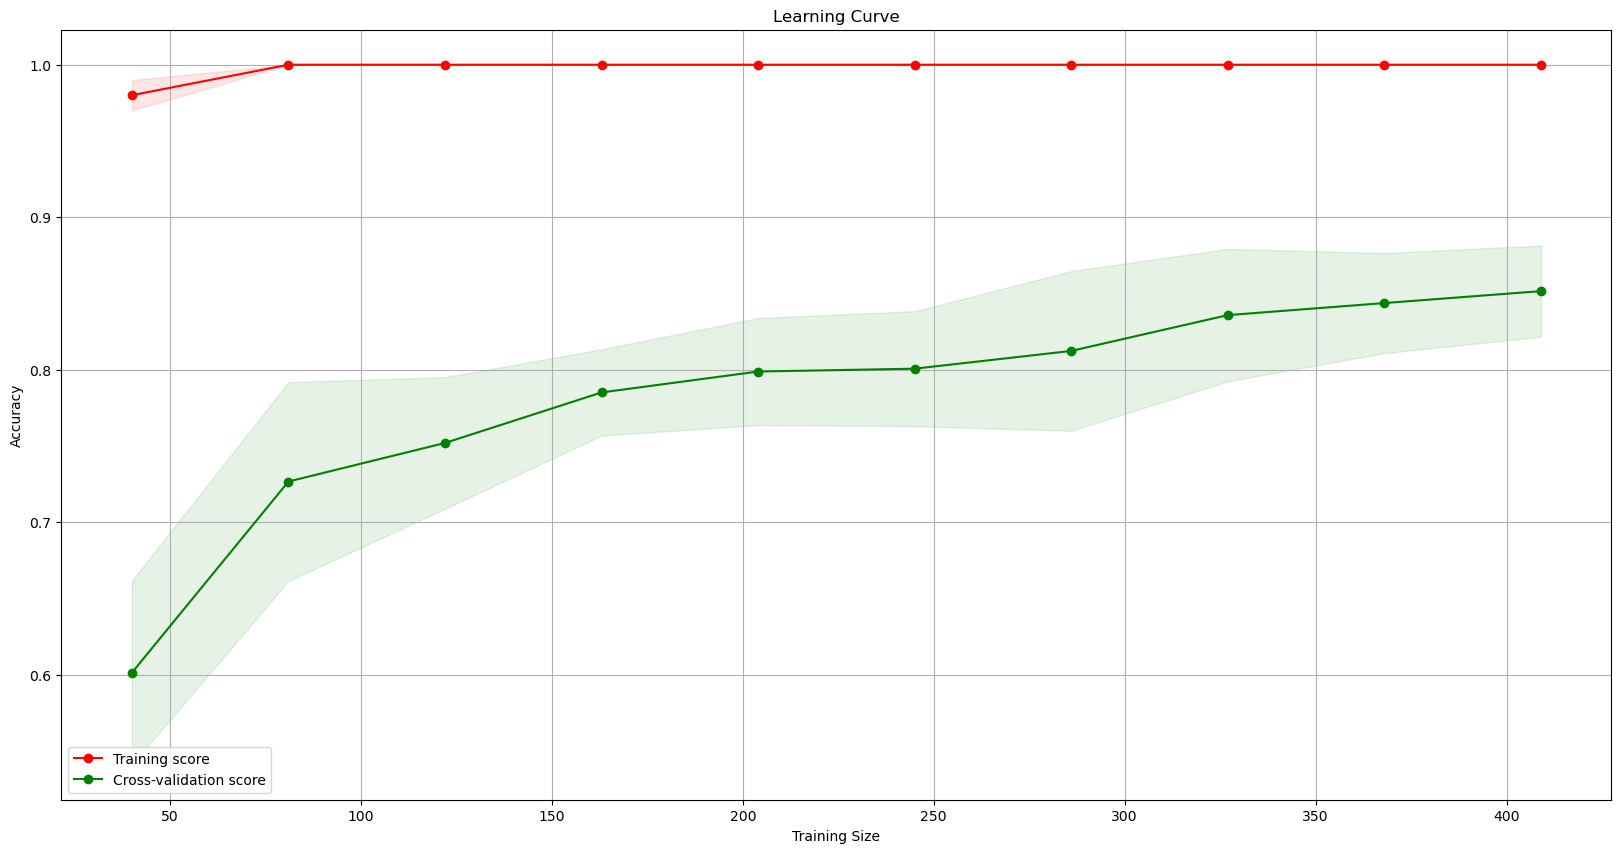

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    calibrated_rf_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(20, 10))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)  # Add grid for better readability
plt.show()


### ROC and AUC

- AUC (Area under the Curve): 
The Area Under the ROC Curve (AUC) measures the entire two-dimensional area underneath the entire ROC curve. The AUC provides an aggregate measure of performance across all possible classification thresholds. It ranges from 0 to 1, where:

  -  *AUC = 0.5:* Represents a model that makes random predictions.
  -  *AUC = 1:* Represents a perfect model.
  - *AUC < 0.5:* Indicates a model that performs worse than random guessing.

    
- ROC Curve: The closer the ROC curve is to the upper left corner, the better the model's performance at distinguishing between the positive and negative classes.
- AUC: The higher the AUC, the better the model is at predicting both positives and negatives correctly. An AUC close to 1 indicates a very good model, while an AUC close to 0.5 indicates a poor model.

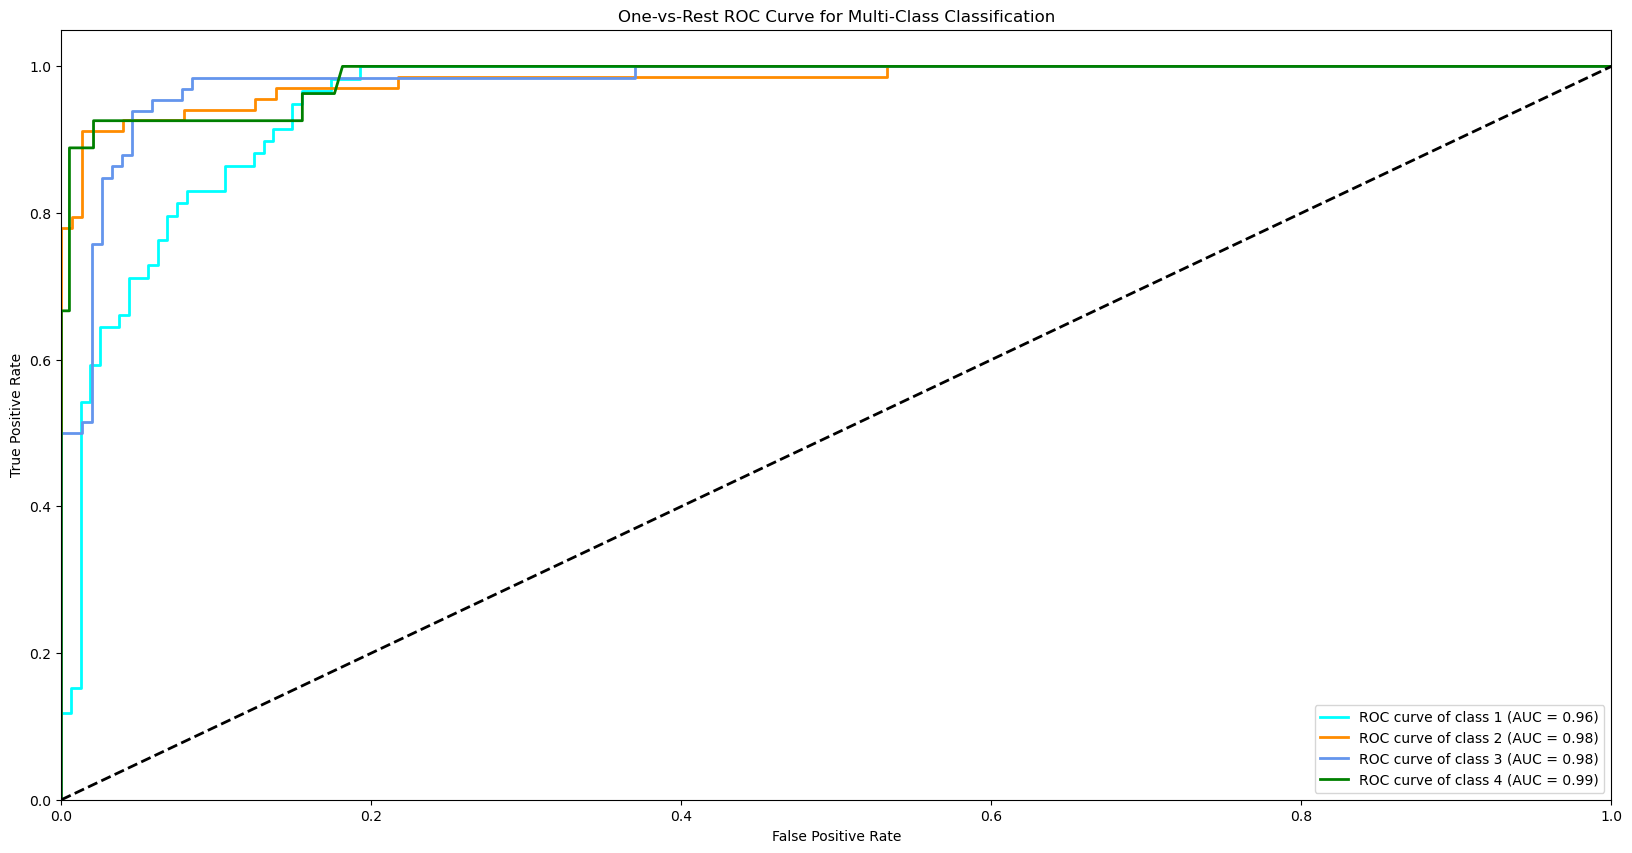

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# rf_model.fit(X_train, y_train)

y_score = best_rf_model.predict_proba(X_test)

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i+1} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Add a diagonal line representing a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

## Feature Importance
### Permutation-based feature importance
Permutation-based feature importance is a learner-agnostic way to judge the relevance of features. It produces an ordinal feature ranking. In order to do this, we permute one variable by shuffling its values across all observations. This means, each observation will receive a new value. This permutation breaks the relationship to the target variable. Then we make an assumption: the higher the increase of the error due to the permutation, the more important this variable was in building the model. This way we can compute a ranking. 

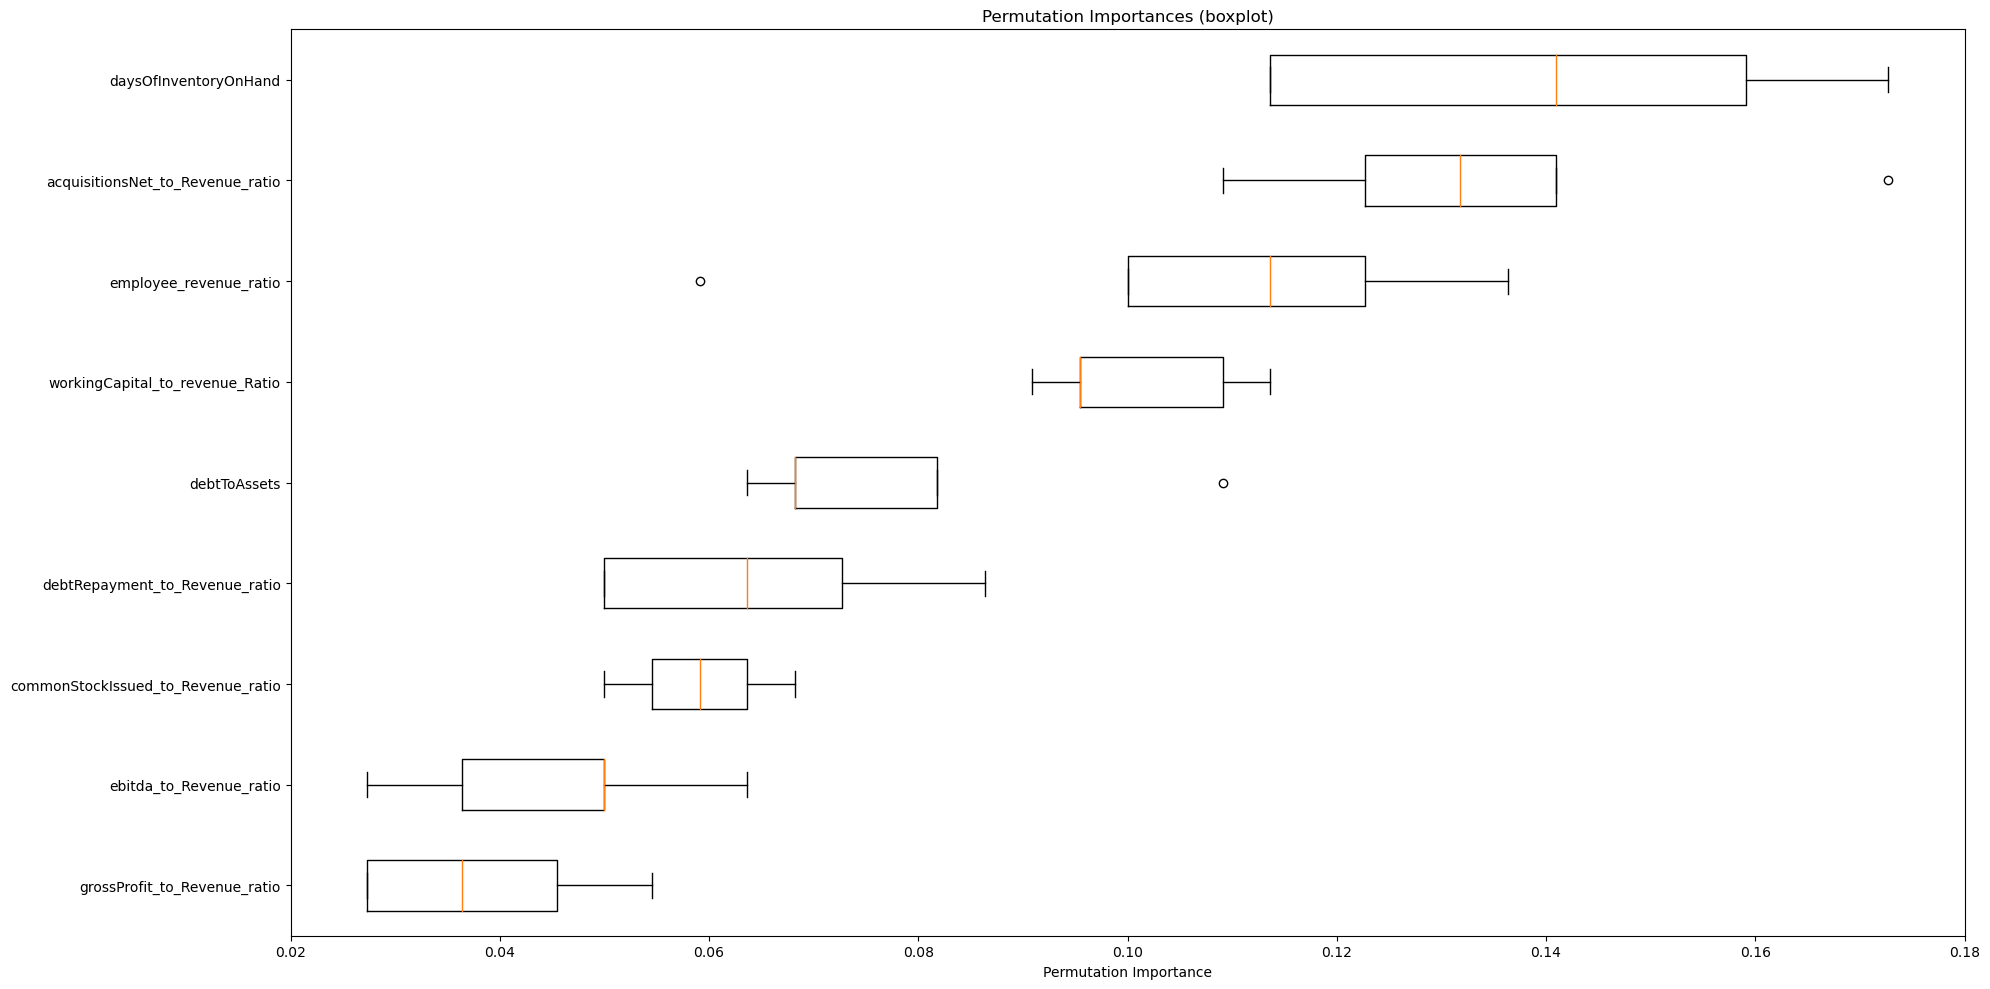

In [12]:
from sklearn.inspection import permutation_importance

plt.rcParams["figure.figsize"] = (20, 10)
classifier = grid_search.best_estimator_

perm_imp = permutation_importance(classifier, X_test, y_test, scoring="accuracy", random_state=123)

sorted_idx = perm_imp.importances_mean.argsort()


fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T, vert=False, labels=X_scaled_df.columns)
ax.set_title("Permutation Importances (boxplot)")
ax.set_xlabel("Permutation Importance")
plt.savefig("Permutation Importance.png")
plt.tight_layout()
plt.show()

### Partial dependence plot (PDP)¶
A PDP shows what type of effect a feature has on predicted probabilities. A PDP plots the values of a chosen variable (on the x-axis) against model-estimated probabilities (on the y-axis) whilst according for the combined effect of all other features.

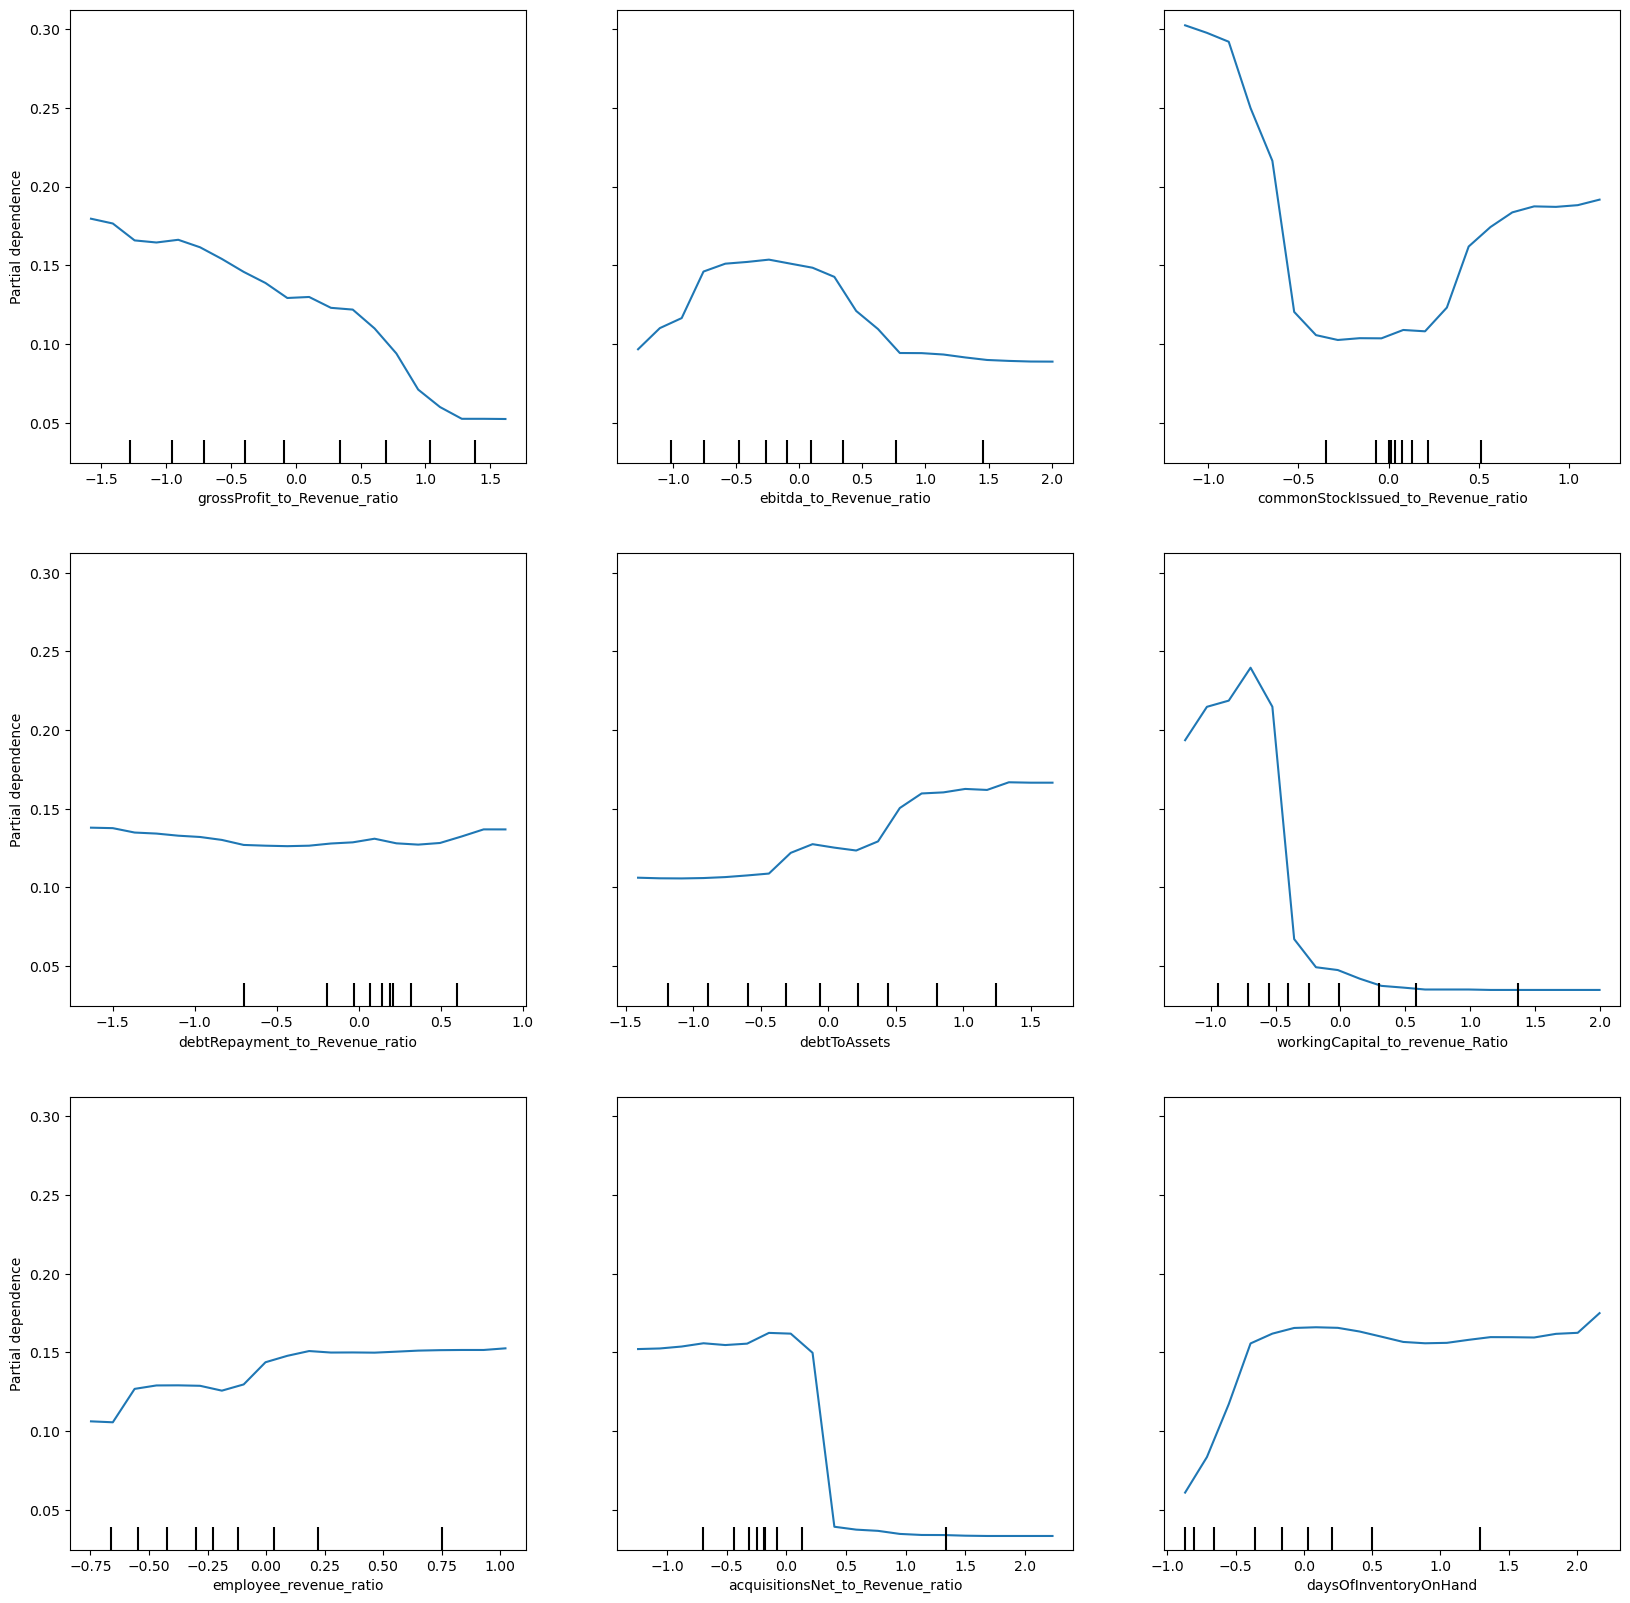

In [13]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams["figure.figsize"] = 20,20

target_class = 4

PartialDependenceDisplay.from_estimator(best_rf_model, X_train, features=X_train.columns,
    target=target_class, n_jobs=3, grid_resolution=20)
plt.show()


#### Top Important Metrics for Classes

- Class 1: Partner, Cost of Rev, Gross Profit, Opex
- Class 2: Partner, COR, Gross, WOC, EV
- Class 3: EV, WOC
- Class 4: EV, WOC, Partner, Gross Profit

### Longitudinal Analysis

In [83]:
import pandas as pd

df_full = pd.read_excel("trans_lit_1980.xlsx")
# df_full.drop(columns=["Unnamed: 0","index", "revenue_to_Revenue_ratio", "marketCap"], axis = 1, inplace = True)
# df_full.drop(columns=["Column1","index_x", "index_y", "revenue_to_Revenue_ratio", "marketCap"], axis = 1, inplace = True)
df_full


,Unnamed: 0,symbol,calendarYear,index,acquisitionsNet_to_Revenue_ratio,investmentsInPropertyPlantAndEquipment_to_Revenue_ratio,commonStockIssued_to_Revenue_ratio,debtRepayment_to_Revenue_ratio,revenue_to_Revenue_ratio,costOfRevenue_to_Revenue_ratio,...,totalCurrentLiabilities_to_totalLiabilities_ratio,totalNonCurrentLiabilities_to_totalLiabilities_ratio,debtToEquity,debtToAssets,marketCap,daysOfInventoryOnHand,workingCapital_to_revenue_Ratio,employee_revenue_ratio,Number of Product Segments,Number of Geo Segments
0,88,CSCO,1980,113,1.339999,-1.073762,0.830360,8.596657,100,33.800654,...,100.977450,-0.977450,-0.117597,0.010491,-2.267430e+10,78.521687,29.650646,0.000215,2.0,3.095571
1,89,CSCO,1981,112,1.184361,-1.100760,0.887982,8.190542,100,33.892238,...,99.567765,0.432235,-0.104167,0.015034,-1.704329e+10,77.295021,30.524968,0.000212,2.0,3.088578
2,90,CSCO,1982,111,1.028723,-1.127758,0.945605,7.784427,100,33.983822,...,98.158080,1.841920,-0.090737,0.019578,-1.141229e+10,76.068354,31.399290,0.000210,2.0,3.081585
3,91,CSCO,1983,110,0.873085,-1.154756,1.003228,7.378312,100,34.075406,...,96.748395,3.251605,-0.077307,0.024122,-5.781290e+09,74.841687,32.273612,0.000207,2.0,3.074592
4,92,CSCO,1984,109,0.717447,-1.181754,1.060851,6.972197,100,34.166990,...,95.338710,4.661290,-0.063877,0.028666,-1.502878e+08,73.615020,33.147934,0.000204,2.0,3.067599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,171,PYPL,2019,109,-15.606596,-207.302709,40.636042,-740.871614,100,45.971191,...,78.243809,21.756191,0.300207,0.098747,1.269916e+11,1.601291,65.136169,0.000131,2.0,2.000000
216,172,PYPL,2020,108,-537.596302,-133.436055,21.109399,-462.249615,100,45.096486,...,76.411082,23.588918,0.453719,0.129058,2.747166e+11,1.218006,58.487928,0.000124,2.0,2.000000
217,173,PYPL,2021,107,-221.882542,-73.049075,13.032985,-29.042639,100,44.834654,...,79.571344,20.428656,0.416440,0.119362,2.213929e+11,0.834722,37.621694,0.000122,2.0,2.000000
218,174,PYPL,2022,106,-161.300429,-35.676097,7.226178,-85.198159,100,49.949124,...,77.170919,22.829081,0.541876,0.139563,8.218788e+10,0.451437,45.119558,0.000109,2.0,2.000000


In [84]:
df_full.dropna(how='any', inplace=True)
df_full.isnull().values.any()

False

In [85]:
df_full_top10 = df_full[["symbol","calendarYear","grossProfit_to_Revenue_ratio", "ebitda_to_Revenue_ratio", 
                "commonStockIssued_to_Revenue_ratio","debtRepayment_to_Revenue_ratio", "debtToAssets",
                "workingCapital_to_revenue_Ratio", "employee_revenue_ratio","acquisitionsNet_to_Revenue_ratio",
                "daysOfInventoryOnHand"]]

In [86]:
def remove_outliers(df):
    # Separate the symbol column
    symbols = df['symbol']
    calendarYear = df['calendarYear']
    
    # Keep only numeric columns for outlier removal
    df_numeric = df.select_dtypes(include=[float])

    # Calculate lower and upper quantiles
    lower_quantiles = df_numeric.quantile(0.01)
    upper_quantiles = df_numeric.quantile(0.99)

    # Filter out the outliers
    for col in df_numeric.columns:
        df_numeric = df_numeric[(df_numeric[col] > lower_quantiles[col]) &
                                (df_numeric[col] < upper_quantiles[col]) &
                                (df_numeric[col] <= 500) &
                                (df_numeric[col] >= -500)]
    
    # Create a filtered DataFrame with the original non-numeric columns
    df_filtered = df.loc[df_numeric.index]
    
    return df_filtered
# Apply the function
filtered_df_full = remove_outliers(df_full_top10)


In [87]:
filtered_df_full

,symbol,calendarYear,grossProfit_to_Revenue_ratio,ebitda_to_Revenue_ratio,commonStockIssued_to_Revenue_ratio,debtRepayment_to_Revenue_ratio,debtToAssets,workingCapital_to_revenue_Ratio,employee_revenue_ratio,acquisitionsNet_to_Revenue_ratio,daysOfInventoryOnHand
0,CSCO,1980,66.199346,28.049917,0.830360,8.596657,0.010491,29.650646,0.000215,1.339999,78.521687
1,CSCO,1981,66.107762,28.143511,0.887982,8.190542,0.015034,30.524968,0.000212,1.184361,77.295021
2,CSCO,1982,66.016178,28.237104,0.945605,7.784427,0.019578,31.399290,0.000210,1.028723,76.068354
3,CSCO,1983,65.924594,28.330697,1.003228,7.378312,0.024122,32.273612,0.000207,0.873085,74.841687
4,CSCO,1984,65.833010,28.424290,1.060851,6.972197,0.028666,33.147934,0.000204,0.717447,73.615020
...,...,...,...,...,...,...,...,...,...,...,...
172,INTC,2020,56.008322,46.540897,85.107683,-34.557813,0.237774,28.889003,0.000142,-5.452879,89.792877
173,INTC,2021,55.445181,43.010984,38.793606,-16.180183,0.226245,38.287103,0.000153,-1.352663,111.711210
174,INTC,2022,42.314524,25.427411,5.806887,-29.985370,0.230919,28.946617,0.000120,37.018906,132.701729
175,INTC,2023,39.719333,20.542893,18.649203,-32.292346,0.257230,28.059305,0.000112,-44.282490,124.242253


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pylab as plt
import numpy as np


y_full = df_full_top10[["symbol", "calendarYear"]]
X_full = df_full_top10.drop(columns=["symbol", "calendarYear"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

X_scaled_full = pd.DataFrame(X_scaled, columns=X_full.columns)

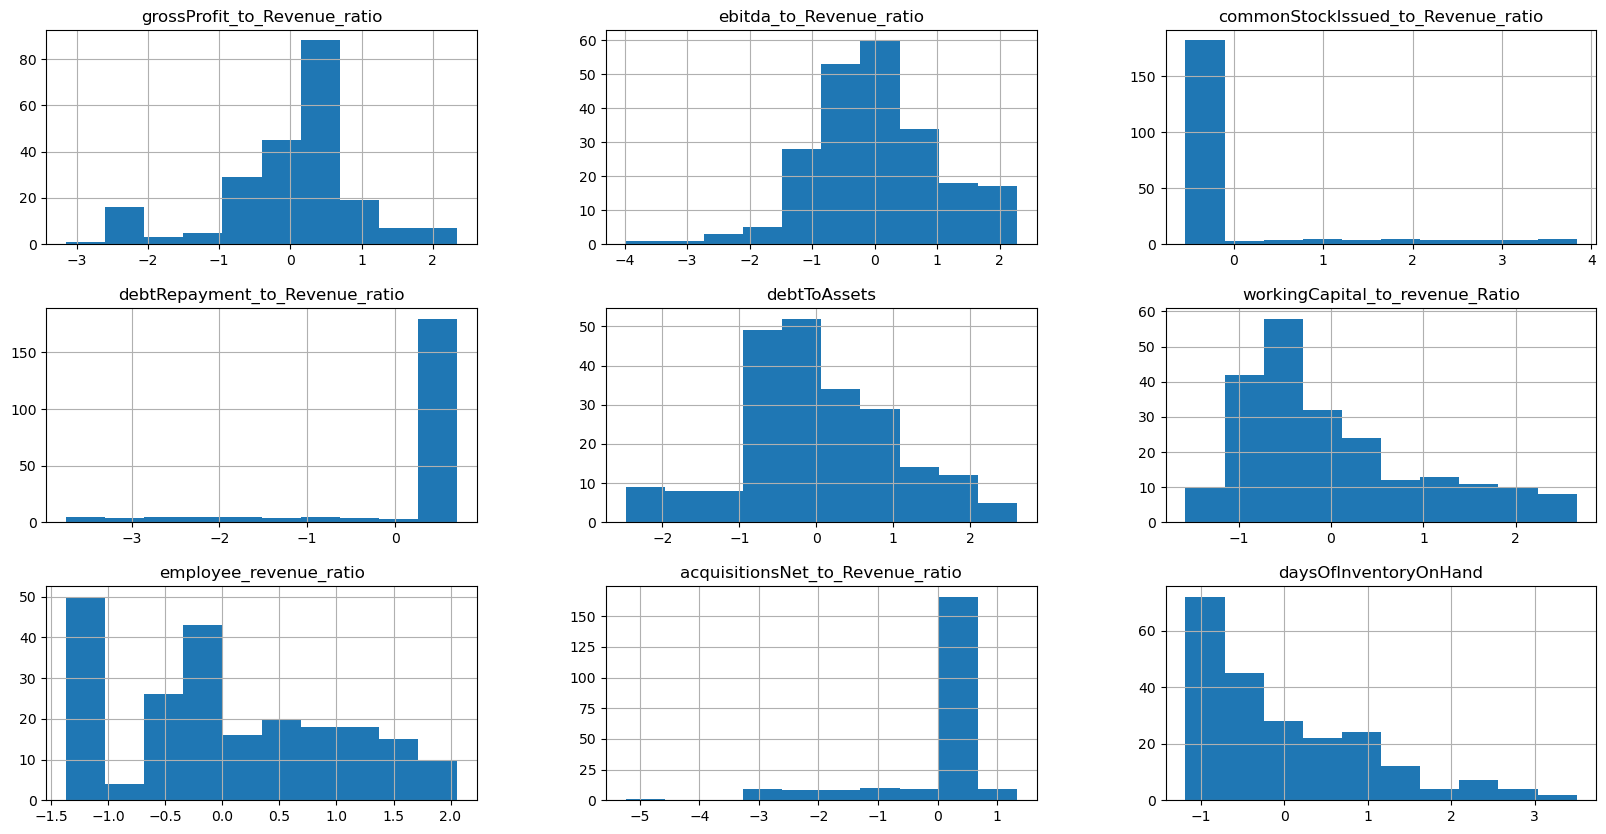

In [89]:

import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (20,10)
X_scaled_full.select_dtypes(exclude="bool").hist(bins=10)
plt.show()

In [90]:
import pandas as pd

predicted_labels = calibrated_rf_model.predict(X_scaled_full)
predicted_labels_df = pd.DataFrame(predicted_labels, columns=['Predicted Labels'])

In [91]:
y_full = y_full.reset_index()
y_full.drop(columns=["index"], axis = 1, inplace = True)
predicted_labels = pd.DataFrame(predicted_labels)
final_df = pd.concat([y_full, X_scaled_full, predicted_labels], axis=1)
final_df = final_df.rename(columns={0: "Predicted Labels"})
final_df["Predicted Labels"].value_counts()

2    173
3     32
1     13
4      2
Name: Predicted Labels, dtype: int64

In [92]:
transition_companies = final_df.groupby('symbol').filter(
    lambda x: (1 in x['Predicted Labels'].values) and (4 in x['Predicted Labels'].values)
)

transition_companies.symbol.unique()
transition_symbols = transition_companies['symbol'].unique()

In [93]:
class_1_companies = final_df.groupby('symbol').filter(
    lambda x: all(label == 1 for label in x['Predicted Labels'].values)
)
class_1_symbols = class_1_companies['symbol'].unique()

# Identify companies that are only in class 4
class_4_companies = final_df.groupby('symbol').filter(
    lambda x: all(label == 4 for label in x['Predicted Labels'].values)
)
class_4_symbols = class_4_companies['symbol'].unique()

# Output the unique symbols for each group
print("Transition Companies (Classes 0 and 3):", transition_symbols)
print("Companies Only in Class 1:", class_1_symbols)
print("Companies Only in Class 4:", class_4_symbols)

Transition Companies (Classes 0 and 3): []
Companies Only in Class 1: []
Companies Only in Class 4: []


In [94]:
import plotly.graph_objects as go


fig = go.Figure()

# Add traces for each company
for symbol in transition_symbols:
    company_data = transition_companies[transition_companies['symbol'] == symbol]
    fig.add_trace(go.Scatter(x=company_data['calendarYear'], y=company_data['Predicted Labels'], mode='lines+markers', name=symbol))

# Create buttons for each company to update visibility
buttons = []
buttons.append(dict(
    label='All',
    method='update',
    args=[{'visible': [True] * len(transition_symbols)}, {'title': 'All Companies'}]
))

for symbol in transition_symbols:
    buttons.append(dict(
        label=symbol,
        method='update',
        args=[{'visible': [symbol == s for s in transition_symbols]},
              {'title': f'Company: {symbol}'}]
    ))

# Update layout to include buttons
fig.update_layout(
    title='Company Label Transitions from 4 to 1 Over Time',
    xaxis_title='Calendar Year',
    yaxis_title='Predicted Labels',
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1.15,
        'xanchor': 'right',
        'y': 1.15,
        'yanchor': 'top'
    }]
)

# Show the plot
fig.show()

In [95]:
import plotly.graph_objects as go

# Define the list of tickers you want to visualize
tickers = ['CSCO', 'HP', 'INTC', 'PYPL', 'IBM']  # Replace with your specific tickers

fig = go.Figure()

# Iterate over the list of tickers and add a trace for each one
for ticker in tickers:
    company_data = final_df[final_df['symbol'] == ticker]
    fig.add_trace(go.Scatter(x=company_data['calendarYear'], y=company_data['Predicted Labels'], mode='lines+markers', name=ticker, visible=True))

# Create buttons for toggling visibility
buttons = []
for i, ticker in enumerate(tickers):
    visible_list = [False] * len(tickers)
    visible_list[i] = True
    buttons.append(dict(label=ticker,
                        method='update',
                        args=[{'visible': visible_list},
                              {'title': f'Label Transitions for {ticker} Over Time'}]))

# Add an "All" button to show all traces
buttons.append(dict(label='All',
                    method='update',
                    args=[{'visible': [True] * len(tickers)},
                          {'title': 'Label Transitions for Multiple Tickers Over Time'}]))

# Update layout with buttons
fig.update_layout(
    updatemenus=[dict(active=0,
                      buttons=buttons,
                      direction="down",
                      x=1.15,
                      xanchor="right",
                      y=1.15,
                      yanchor="top")],
    title='Label Transitions for Multiple Tickers Over Time',
    xaxis_title='Calendar Year',
    yaxis_title='Predicted Labels',
    legend_title='Ticker'
)

# Show the plot
fig.show()


In [96]:
filtered_df_full.symbol.unique()

array(['CSCO', 'HP', 'INTC', 'PYPL'], dtype=object)

In [97]:
company_data = final_df[final_df['symbol'] == specific_ticker]

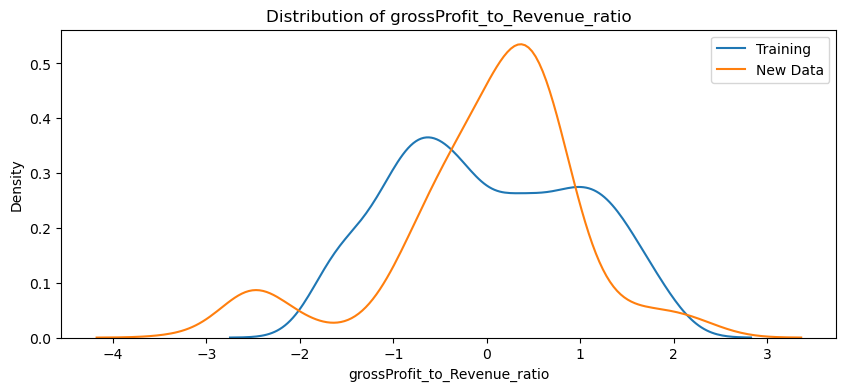

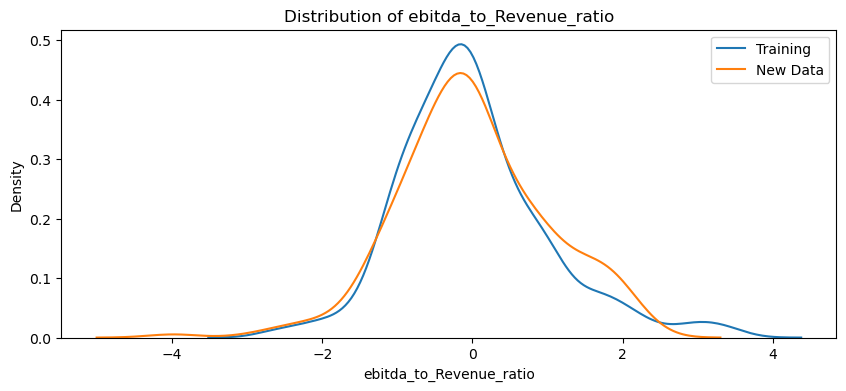

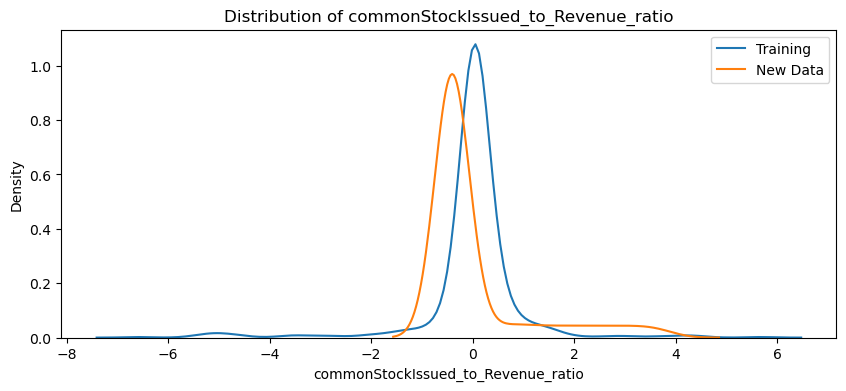

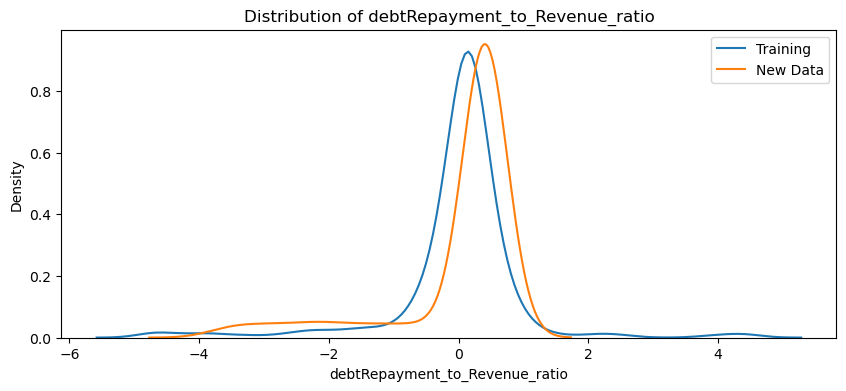

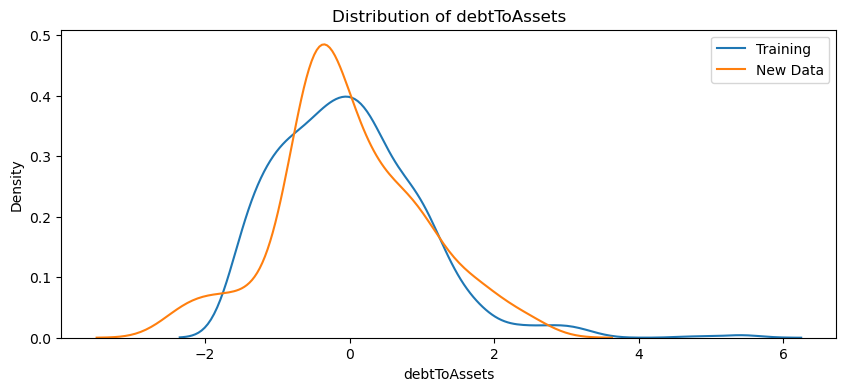

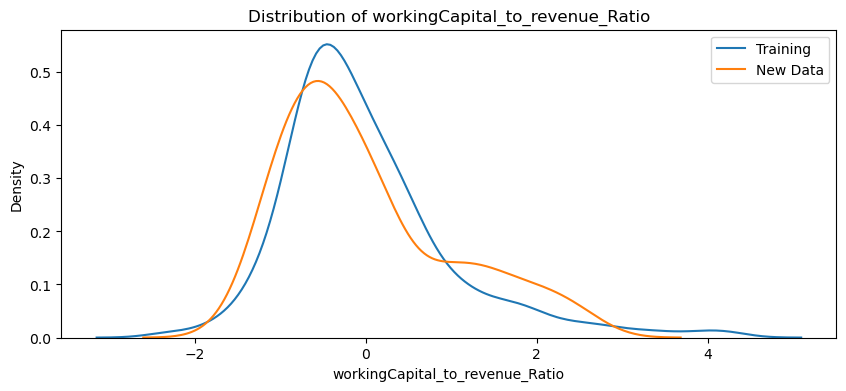

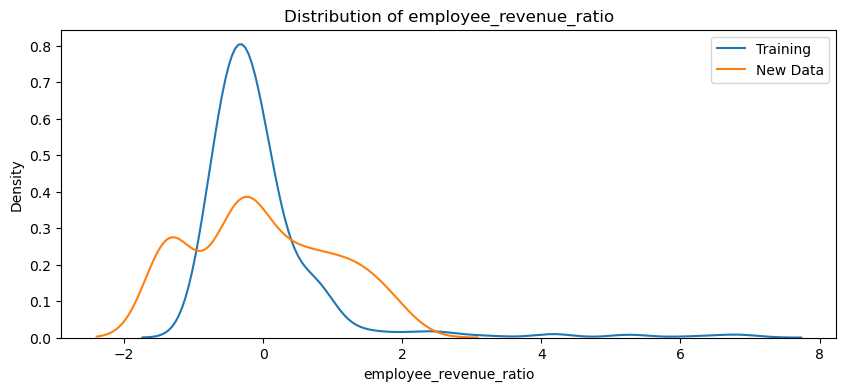

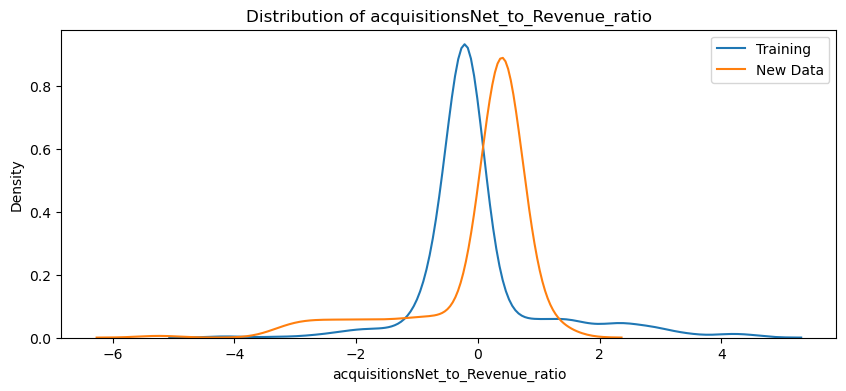

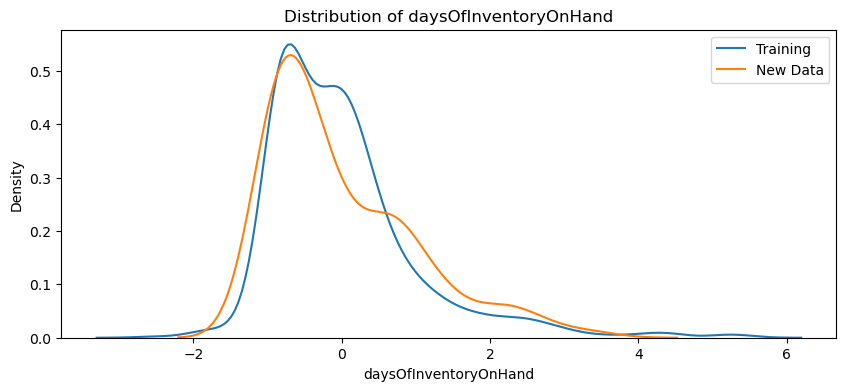

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train is your training set and X_new is your new dataset
def plot_feature_distributions(X_train, X_new):
    for column in X_train.columns:
        plt.figure(figsize=(10, 4))
        sns.kdeplot(X_train[column], label='Training')
        sns.kdeplot(X_new[column], label='New Data')
        plt.title(f'Distribution of {column}')
        plt.legend()
        plt.show()

plot_feature_distributions(X_scaled_df, X_scaled_full)
